# Airbnb insights of Sevilla, Spain

In this notebook, I will be doing some analysis of the data downloaded from the Airbnb website for the spanish city of Sevilla


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Seasonality, price variability and availability](#Seasonality-and-price-variability)<br>
III. [Popularity of the different neighborhoods](#Popularity-of-the-different-neighborhoods)<br>
IV. [Impact of the pandemic](#Impact-of-the-pandemic)<br>
V. [Popular words describing the neighborhoods of Sevilla](#Popular-words-describing-the-neighborhoods-of-Sevilla)<br>


1. Is Sevilla a popular city the whole year or is seasonal? How price and availability change?
2. How has changed the market through the years? What is the impact of the pandemic in the market?
3. Is there a relationship between neighbourhood and price?
4. Which words are the most used by tourists when doing a review?

In [1130]:
# Let's get started by importing the necessary libraries and reading in the data.
import pandas as pd
import numpy as np
from itertools import cycle, islice

import matplotlib.pyplot as plt
import seaborn as sns

#% pip install wordcloud
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import string
from collections import Counter

import nltk
import os

import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

# display setup
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('max_colwidth', 200)

In [1131]:
listing = pd.read_csv('listings.csv')
review = pd.read_csv('reviews.csv')
calendar = pd.read_csv('calendar.csv')
neighbourhoods = pd.read_csv('neighbourhoods.csv')

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Below I will provide some insight into the descriptive statistics of the data.

`1.` Overview of the datasets

In [1132]:
print('Excerpt of the \'listings\' dataset:')
listing.head(4)

Excerpt of the 'listings' dataset:


id                                                      name  host_id  \
0   32347  Explore Cultural Sights from a Family-Friendly Apartment   139939   
1   49287                            BEAUTIFUL APARTMENT IN SEVILLE   224697   
2   94187          (2) ROOM + PRIVATE BATHROOM. CASA DEL BUEN VIAJE   503692   
3  108568                     TERRACE ALAMEDA. WIFI GARAGE DOWNTOWN   589600   

   host_name neighbourhood_group  neighbourhood  latitude  longitude  \
0  Alejandro       Casco Antiguo    San Vicente  37.39468   -6.00183   
1     Walter       Casco Antiguo          Feria  37.39855   -5.99365   
2     Margot       Casco Antiguo  San Bartolomé  37.39012   -5.98676   
3     Miguel       Casco Antiguo          Feria  37.39939   -5.99237   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0  Entire home/apt     99               2                168  2020-01-08   
1  Entire home/apt     55               1                 42  2020-02-17   
2     Private room     59               2                 75  2019-06-05   
3  Entire home/apt     65               3                 81  2019-12-29   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               1.37                               1               257  
1               0.35                               1               302  
2               0.66                               6               245  
3               0.71                              13               341

In [1133]:
print('Excerpt of the \'reviews\' dataset:')
review.head(4)

Excerpt of the 'reviews' dataset:


listing_id       id        date  reviewer_id reviewer_name  \
0       32347   166105  2011-01-05       177444         Peter   
1       32347   238321  2011-04-25       356558      Nicholas   
2       32347   508902  2011-09-06       723051        Nadine   
3       32347  1056439  2012-03-28       873621         Cathy   

                                                                                                                                                                                                  comments  
0                                                                                                                                                                           Great location and great host!  
1                                                                                                                                                                      excellent apartment, great location  
2  My  parents and I had a fabulous stay in Alex's apartment. Such a great first experience of stunning Seville. Just as described the apartment is only 5 minutes walk to Sierpes, which is the main s...  
3  We had a fantastic stay.  Alex's apartment is beautiful; clean, uncluttered, yet homely.  Alex was a great host, flexible to our timings, very generous with extra treats and very friendly. Seville...

In [1134]:
print('Excerpt of the \'calendar\' dataset:')
calendar.head(4)

Excerpt of the 'calendar' dataset:


listing_id        date available   price adjusted_price  minimum_nights  \
0      879051  2021-02-01         t  $50.00         $50.00             2.0   
1       32347  2021-01-31         f  $99.00         $99.00             2.0   
2       32347  2021-02-01         f  $99.00         $99.00             2.0   
3       32347  2021-02-02         f  $99.00         $99.00             2.0   

   maximum_nights  
0           365.0  
1          1125.0  
2          1125.0  
3          1125.0

In [1135]:
print('Excerpt of the \'neighbourhoods\' dataset:')
neighbourhoods.head(4)

Excerpt of the 'neighbourhoods' dataset:


neighbourhood_group        neighbourhood
0       Casco Antiguo              Alfalfa
1       Casco Antiguo               Arenal
2       Casco Antiguo  Encarnación, Regina
3       Casco Antiguo                Feria

`2.` Check for columns that have missing values

In [1136]:
nulls_listing = set(listing.columns[listing.isnull().mean()!=0])
print('Columns with null values in the \'listings\'dataset:', nulls_listing)

nulls_calendar = set(calendar.columns[calendar.isnull().mean()!=0])
print('Columns with null values in the \'calendar\'dataset:', nulls_calendar)

nulls_review = set(review.columns[review.isnull().mean()!=0])
print('Columns with null values in the \'reviews\'dataset:', nulls_review)

nulls_neighbourhoods = set(neighbourhoods.columns[neighbourhoods.isnull().mean()!=0])
print('Columns with null values in the \'neighbourhoods\'dataset:', nulls_neighbourhoods)

Columns with null values in the 'listings'dataset: {'last_review', 'host_name', 'reviews_per_month'}
Columns with null values in the 'calendar'dataset: {'maximum_nights', 'minimum_nights'}
Columns with null values in the 'reviews'dataset: {'comments'}
Columns with null values in the 'neighbourhoods'dataset: set()


### <a class="anchor" id="Seasonality-and-price-variability">Part II : Seasonality, price variability and availability</a>

The aim of this section is to find out how popular Sevilla is through the year and if it has an impact on the price

`1.` What are the most popular months?

Here I will be using the review and calendar datasets. The date column needs to be split to use it

In [1137]:
# Function to split the date column
def split_date(df, column):
    df[column] =  pd.to_datetime(df[column])
    df[column+'_year'] = df[column].apply(lambda x: x.year)
    df[column+'_month'] = df[column].apply(lambda x: x.month)
    df[column+'_day'] = df[column].apply(lambda x: x.day)
    df[column+'_dayofweek'] = df[column].apply(lambda x: x.strftime('%A'))
    
# date column split
split_date(review, 'date')

In [1138]:
# Check the possible duplicates in reviews by the id of the review
review[review.duplicated(subset = 'id')]

Empty DataFrame
Columns: [listing_id, id, date, reviewer_id, reviewer_name, comments, date_year, date_month, date_day, date_dayofweek]
Index: []

In [1139]:
review.groupby(['date_month'])['listing_id'].count()

date_month
1     20656
2     21260
3     22175
4     24278
5     27595
6     22891
7     18772
8     19749
9     28720
10    33619
11    22854
12    20013
Name: listing_id, dtype: int64

In [1140]:
# Mean value of reviews per month on the dataset
mean_reviews = review.shape[0]/12

/Users/petanth/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


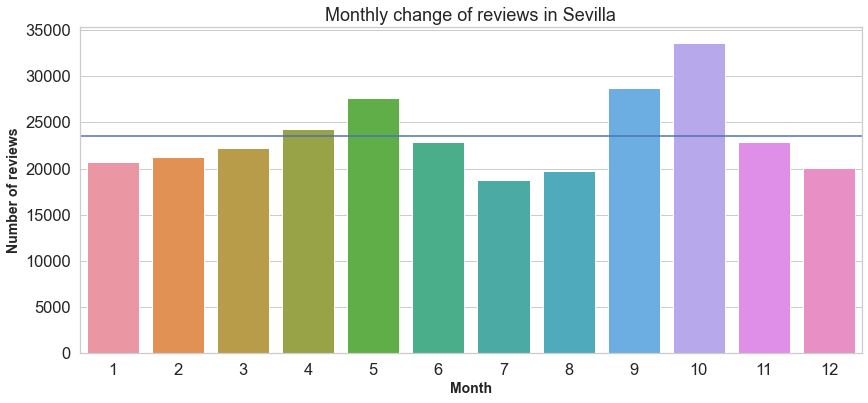

In [1141]:
plt.figure(figsize = (14,6))
x = sns.countplot(review.date_month)
x.axhline(mean_reviews, ls='-')
var = x.set_title('Monthly change of reviews in Sevilla', fontsize=18)
var = x.set_xlabel('Month', fontsize=14, weight='bold')
var = x.set_ylabel('Number of reviews', fontsize=14, weight='bold')

#### As can be seen in the graphic above, the popularity has some variablity depending on the month of the year.
The following can be concluded:
- 4 months have above average visits: April, May, September and October. These coincide with moments in which people usually have holidays and also the weather in the city is more favourable to do tourism
- 2 months show a clear drop in visits: July and August. These months coincide with the moment in the year with higher temperatures in the city, with maximum average of 36 degrees and peaks of 45 degrees. If we add the fact that July and August are typical months when cities with coast are more popular and Sevilla has no coast, is clear why the descent in visits in this period of time on the year
- The rest of the months are below visit average but the drop is not very pronounced

`2.` How the price changes through the months?

The date column needs to be split to use it and the price need to be converted

In [1142]:
# Split date data
split_date(calendar, 'date')

# Convert the price to int
def convPrice(df, column):
    df[column] = df[column].str.replace('$', '')
    df[column] = df[column].str.replace(',', '')
    df[column] = df[column].astype(float)
convPrice(calendar, 'price')
convPrice(calendar, 'adjusted_price') 

Let's first take a look at the mean prices per night for each month and plot the values:

In [1143]:
calendar.groupby(['date_month'])['price', 'adjusted_price'].mean()

<ipython-input-1143-324b06fc1120>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  calendar.groupby(['date_month'])['price', 'adjusted_price'].mean()


price  adjusted_price
date_month                            
1           633.757004      632.257530
2           136.426432      136.075559
3           163.976261      163.517113
4           212.325560      211.427187
5           193.820761      192.828836
6           242.660036      241.722214
7           271.131347      270.393410
8           284.547445      283.767157
9           405.532134      404.591072
10          416.001483      415.310884
11          411.984102      410.996836
12          426.656943      425.853833

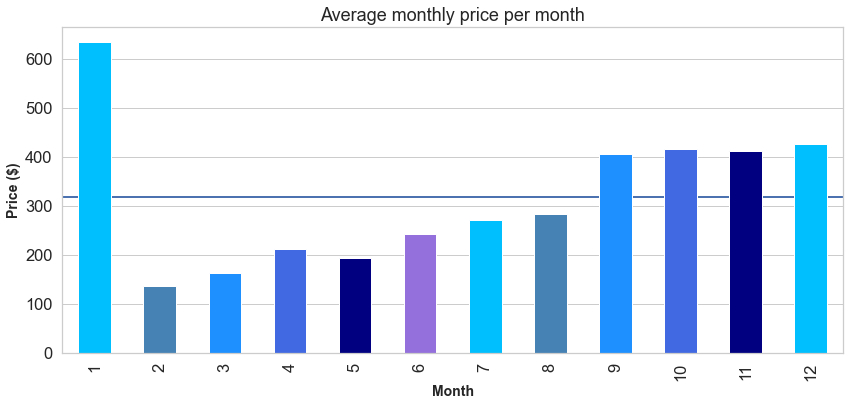

In [1144]:
my_colors = list(islice(cycle(['deepskyblue', 'steelblue', 'dodgerblue', 'royalblue', 'navy', 'mediumpurple']), None, len((neighbourhoods.neighbourhood_group.unique()))))

plt.figure(figsize = (14,6))
calendar.groupby(['date_month'])['price'].mean().plot(kind = "bar", color = my_colors, zorder=2)
plt.title("Average monthly price per month", fontsize=18)
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Price ($)', fontsize=14, fontweight='bold')
plt.axhline(y=calendar.price.mean(), linewidth=2, color='b',zorder=1)
plt.grid(axis='x')
plt.show()

It does not make much sense that the average price per night ranges from around 200 until more than 600.
Looking at properties of the dataset we obtain the following:


In [1145]:
calendar.groupby(['date_month'])['price', 'adjusted_price'].describe()

<ipython-input-1145-d626ab18fe58>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  calendar.groupby(['date_month'])['price', 'adjusted_price'].describe()


price                                                   \
               count        mean          std  min   25%   50%    75%   
date_month                                                              
1           164649.0  633.757004  2010.703940  8.0  50.0  80.0  160.0   
2           148652.0  136.426432   638.345956  8.0  45.0  65.0   95.0   
3           164579.0  163.976261   679.935193  9.0  50.0  73.0  120.0   
4           159270.0  212.325560   712.280325  9.0  56.0  90.0  165.0   
5           164579.0  193.820761   790.163314  9.0  55.0  80.0  135.0   
6           159270.0  242.660036   948.197679  9.0  51.0  80.0  131.0   
7           164579.0  271.131347  1084.345969  9.0  50.0  75.0  123.0   
8           164579.0  284.547445  1144.590327  9.0  50.0  75.0  120.0   
9           159270.0  405.532134  1538.712689  9.0  51.0  80.0  146.0   
10          164579.0  416.001483  1558.505194  9.0  52.0  80.0  150.0   
11          159270.0  411.984102  1563.075682  9.0  50.0  79.0  135.0   
12          164579.0  426.656943  1590.291990  9.0  50.0  80.0  150.0   

                    adjusted_price                                            \
                max          count        mean          std  min   25%   50%   
date_month                                                                     
1           10499.0       164649.0  632.257530  2007.770396  8.0  50.0  80.0   
2           11498.0       148652.0  136.075559   637.704086  8.0  45.0  65.0   
3           11498.0       164579.0  163.517113   679.617984  9.0  50.0  73.0   
4           11498.0       159270.0  211.427187   710.536945  9.0  55.0  90.0   
5           11498.0       164579.0  192.828836   788.649816  9.0  55.0  80.0   
6           11498.0       159270.0  241.722214   946.945498  9.0  51.0  80.0   
7           10999.0       164579.0  270.393410  1083.478495  9.0  50.0  75.0   
8           10999.0       164579.0  283.767157  1143.559015  9.0  50.0  75.0   
9           10999.0       159270.0  404.591072  1537.028327  9.0  50.0  80.0   
10          10999.0       164579.0  415.310884  1556.823479  9.0  51.0  80.0   
11          10999.0       159270.0  410.996836  1561.366753  9.0  50.0  79.0   
12          10999.0       164579.0  425.853833  1588.612238  9.0  50.0  80.0   

                            
              75%      max  
date_month                  
1           160.0  10000.0  
2            94.0  11498.0  
3           120.0  11498.0  
4           164.0  11498.0  
5           135.0  11498.0  
6           130.0  11498.0  
7           122.0  10999.0  
8           120.0  10999.0  
9           145.0  10999.0  
10          150.0  10999.0  
11          135.0  10999.0  
12          150.0  10999.0

It seems there are some outliers on the price as values with anormaly high prices per night. The maximum value of the price can reach 11498 on the dataset and it is not representative of the reality. Most likely these outliers are making our average values per month very high. 

A histogram, boxplot and scatterplot of the price data will be represented to understand better the distribution of prices on the dataset

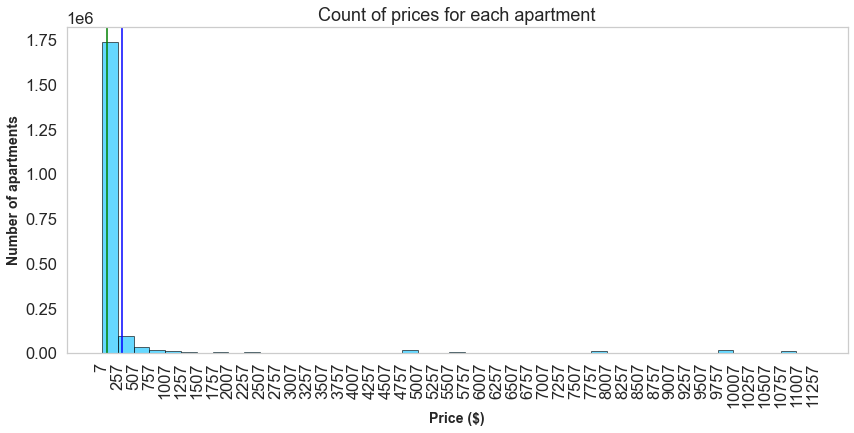

In [1146]:
n_bins = np.arange(calendar.price.min()-1,calendar.price.max(),250)

plt.figure(figsize = (14,6))
plt.hist(calendar.price, bins = n_bins, alpha=0.6, histtype='bar', ec='black', color = "deepskyblue");
plt.title('Count of prices for each apartment', fontsize=18)
plt.xlabel('Price ($)', fontsize=14, fontweight='bold')
plt.ylabel('Number of apartments', fontsize=14, fontweight='bold')
plt.axvline(x = calendar.price.mean(),color = 'blue')
plt.axvline(x = calendar.price.median(),color = 'green')
plt.xticks(n_bins, rotation=90)
plt.grid(False)
plt.show()

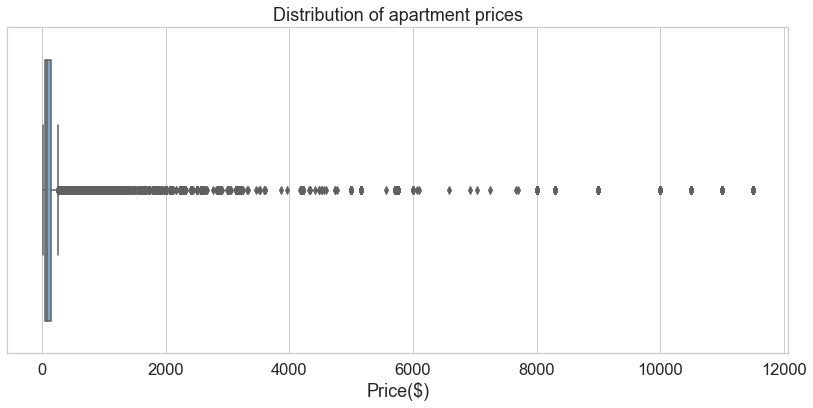

In [1147]:
ax = sns.set(rc={'figure.figsize':(14,6)}, font_scale=1.5, style='whitegrid')
ax = sns.boxplot(x="price", data=calendar, palette="Blues")
ax.set_title('Distribution of apartment prices');
ax.set_xlabel('Price($)');

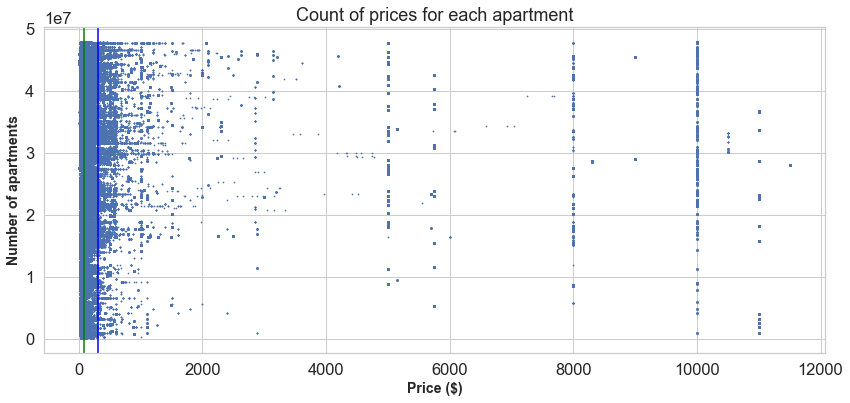

In [1148]:
plt.figure(figsize = (14,6))
plt.scatter(calendar['price'], calendar['listing_id'], s = 0.5)
plt.title('Count of prices for each apartment', fontsize=18)
plt.xlabel('Price ($)', fontsize=14, fontweight='bold')
plt.ylabel('Number of apartments', fontsize=14, fontweight='bold')
plt.axvline(x = calendar.price.mean(),color = 'blue');
plt.axvline(x = calendar.price.median(),color = 'green');

It can be seen that there are values that can be considered as outliers for the price since the majority of the prices are between 0 and 250. I will check the meadian values for the price since it is a descriptive statistic that is more robust than the mean against outliers

In [1149]:
calendar.groupby(['date_month'])['price', 'adjusted_price'].median()

<ipython-input-1149-5d5f45e1df11>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  calendar.groupby(['date_month'])['price', 'adjusted_price'].median()


price  adjusted_price
date_month                       
1            80.0            80.0
2            65.0            65.0
3            73.0            73.0
4            90.0            90.0
5            80.0            80.0
6            80.0            80.0
7            75.0            75.0
8            75.0            75.0
9            80.0            80.0
10           80.0            80.0
11           79.0            79.0
12           80.0            80.0

The values I obtain are much more reasonable than the values obtained with the mean.

Another method to detect outliers is the IQR (Interquantile Range) that I will calculate here:

In [1150]:
# Use of IQR (Interquantile Range) to detect outliers in price
Q1_price = calendar.price.quantile(0.25)
Q3_price = calendar.price.quantile(0.75)
IQR_price = Q3_price - Q1_price
print('IQR for price values:', IQR_price)

IQR for price values: 85.0


This also give us a much more reasonable average price. The values out of the IQR will be deleted from the dataset:

In [1151]:
calendar_new = calendar[['price', 'adjusted_price', 'date_month']]
calendar_new.dtypes

Q1 = calendar_new.quantile(0.25)
Q3 = calendar_new.quantile(0.75)
IQR = Q3 - Q1

df_out = calendar_new[~((calendar_new < (Q1 - 1.5 * IQR)) |(calendar_new > (Q3 + 1.5 * IQR))).any(axis=1)]

print('Rows on the original dataset:', calendar.shape[0])
print('Rows on the new dataset after deleting the outliers:', df_out.shape[0])
print('Deleted rows:', calendar.shape[0]-df_out.shape[0])

Rows on the original dataset: 1937855
Rows on the new dataset after deleting the outliers: 1738179
Deleted rows: 199676


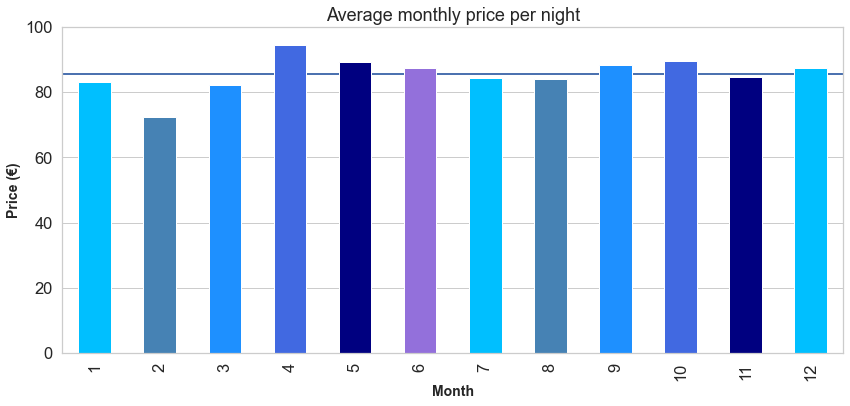

In [1152]:
my_colors = list(islice(cycle(['deepskyblue', 'steelblue', 'dodgerblue', 'royalblue', 'navy', 'mediumpurple']), None, len((neighbourhoods.neighbourhood_group.unique()))))

plt.figure(figsize = (14,6))
df_out.groupby(['date_month'])['price'].mean().plot(kind = "bar", color = my_colors, zorder=2)
plt.title("Average monthly price per night", fontsize=18)
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Price (€)', fontsize=14, fontweight='bold')
plt.axhline(y=df_out.price.mean(), linewidth=2, color='b',zorder=1)
plt.grid(axis='x')
plt.ylim(0, 100)
plt.show()

#### As can be seen in the graphic above, the average monthly price per night makes now much more sense.

We can see that the most popular months (April, May, September and October) are also those that have higher average price per night

`3.` How the availability changes depending on the month?

In [1153]:
# Dummies will be generated to separate available data in 0 or 1 values
calendar_availability = pd.get_dummies(calendar, columns = ['available'])
calendar_availability.groupby(['date_month'])['available_t'].describe()
calendar_availability

listing_id       date  price  adjusted_price  minimum_nights  \
0            879051 2021-02-01   50.0            50.0             2.0   
1             32347 2021-01-31   99.0            99.0             2.0   
2             32347 2021-02-01   99.0            99.0             2.0   
3             32347 2021-02-02   99.0            99.0             2.0   
4             32347 2021-02-03   99.0            99.0             2.0   
...             ...        ...    ...             ...             ...   
1937850    47947887 2022-01-26   49.0            49.0             1.0   
1937851    47947887 2022-01-27   49.0            49.0             1.0   
1937852    47947887 2022-01-28   49.0            49.0             1.0   
1937853    47947887 2022-01-29   49.0            49.0             1.0   
1937854    47947887 2022-01-30   49.0            49.0             1.0   

         maximum_nights  date_year  date_month  date_day date_dayofweek  \
0                 365.0       2021           2         1         Monday   
1                1125.0       2021           1        31         Sunday   
2                1125.0       2021           2         1         Monday   
3                1125.0       2021           2         2        Tuesday   
4                1125.0       2021           2         3      Wednesday   
...                 ...        ...         ...       ...            ...   
1937850          1125.0       2022           1        26      Wednesday   
1937851          1125.0       2022           1        27       Thursday   
1937852          1125.0       2022           1        28         Friday   
1937853          1125.0       2022           1        29       Saturday   
1937854          1125.0       2022           1        30         Sunday   

         available_f  available_t  
0                  0            1  
1                  1            0  
2                  1            0  
3                  1            0  
4                  1            0  
...              ...          ...  
1937850            0            1  
1937851            0            1  
1937852            0            1  
1937853            0            1  
1937854            0            1  

[1937855 rows x 12 columns]

In [1154]:
calendar_availability.groupby(['date_month'])['available_t'].mean()

date_month
1     0.429495
2     0.666241
3     0.688065
4     0.641521
5     0.608413
6     0.619935
7     0.629333
8     0.527321
9     0.506159
10    0.501085
11    0.479080
12    0.474410
Name: available_t, dtype: float64

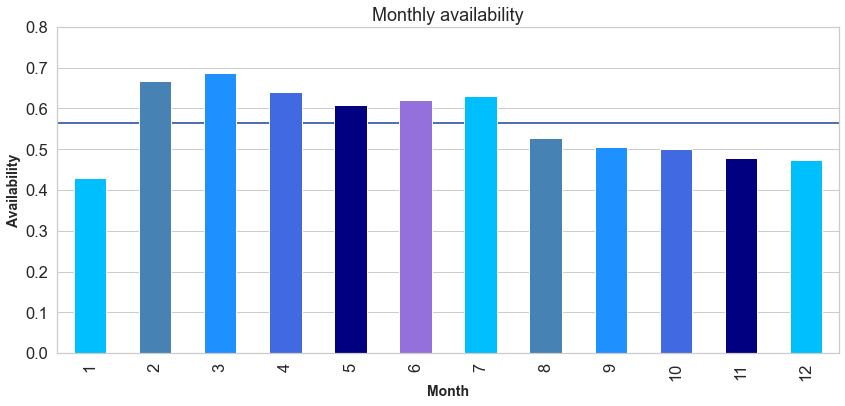

In [1155]:
my_colors = list(islice(cycle(['deepskyblue', 'steelblue', 'dodgerblue', 'royalblue', 'navy', 'mediumpurple']), None, len((neighbourhoods.neighbourhood_group.unique()))))


plt.figure(figsize = (14,6))
calendar_availability.groupby(['date_month'])['available_t'].mean().plot(kind = "bar", color = my_colors, zorder=2)
plt.title("Monthly availability", fontsize=18)
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Availability', fontsize=14, fontweight='bold')
plt.axhline(y=calendar_availability.available_t.mean(), linewidth=2, color='b',zorder=1)
plt.grid(axis='x')
plt.ylim(0, 0.8)
plt.show()

Here I will delete the rows with outliers in price and check if it has an impact in the availability:

In [1156]:
calendar_av_new = calendar_availability[['price', 'adjusted_price', 'date_month', 'available_f', 'available_t']]
#calendar_av_new.dtypes

Q1 = calendar_av_new.quantile(0.25)
Q3 = calendar_av_new.quantile(0.75)
IQR = Q3 - Q1

df_av_out = calendar_av_new[~((calendar_av_new < (Q1 - 1.5 * IQR)) |(calendar_av_new > (Q3 + 1.5 * IQR))).any(axis=1)]

print('Rows on the original dataset:', calendar_availability.shape[0])
print('Rows on the new dataset after deleting the outliers:', df_av_out.shape[0])
print('Deleted rows:', calendar_availability.shape[0]-df_av_out.shape[0])

Rows on the original dataset: 1937855
Rows on the new dataset after deleting the outliers: 1738179
Deleted rows: 199676


In [1157]:
df_1 = calendar_availability.groupby(['date_month'])['available_t'].mean()
df_2 = df_av_out.groupby(['date_month'])['available_t'].mean()

compare_df = {'Including outliers in availability': df_1,
              'Without outliers in availability': df_2}

df_new = pd.DataFrame(compare_df, columns=['Including outliers in availability', 'Without outliers in availability'])

In [1158]:
my_colors = list(islice(cycle(['deepskyblue', 'steelblue', 'dodgerblue', 'royalblue', 'navy', 'mediumpurple']), None, len((neighbourhoods.neighbourhood_group.unique()))))


plt.figure(figsize = (14,6))
df_new.plot(kind = "bar", color = my_colors, zorder=2)
plt.title("Monthly availability", fontsize=18)
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Availability', fontsize=14, fontweight='bold')
plt.axhline(y=calendar_availability.available_t.mean(), linewidth=2, color='r',zorder=1)
plt.axhline(y=df_av_out.available_t.mean(), linewidth=2, color='b',zorder=1)
plt.grid(axis='x')
#plt.grid(False)
#plt.ylim(0, 0.8)
plt.show()

<Figure size 1008x432 with 0 Axes>

As can be seen in the graphic above, removing the outliers barely have an impact in the availability. Also as general rule, on the first part of the year the availability seems to be higher

### <a class="anchor" id="Popularity-of-the-different-neighborhoods">Part III : Popularity of the different neighborhoods</a>

The aim of this section is to study the peculiarities of the different neighborhoods in Sevilla

`1.` What are the neighborhoods with the highest offer of apartments?

Number of neighbourhoods on the dataset 11


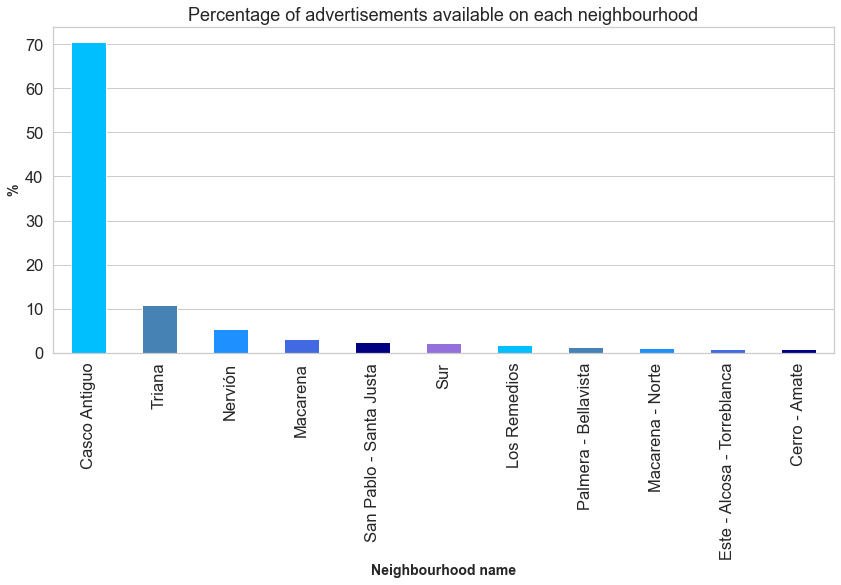

In [1159]:
print('Number of neighbourhoods on the dataset', len(neighbourhoods.neighbourhood_group.unique()))

my_colors = list(islice(cycle(['deepskyblue', 'steelblue', 'dodgerblue', 'royalblue', 'navy', 'mediumpurple']), None, len((neighbourhoods.neighbourhood_group.unique()))))

status_vals = listing.neighbourhood_group.value_counts()
plt.figure(figsize = (14,6))
((status_vals/listing.shape[0])*100).plot(kind="bar", color=my_colors, stacked=True)
plt.title("Percentage of advertisements available on each neighbourhood", fontsize=18)
plt.xlabel('Neighbourhood name', fontsize=14, fontweight='bold')
plt.ylabel('%', fontsize=14, fontweight='bold')
plt.grid(axis='x')
plt.show()

From the above graphic can be observed that the neighbourhood with the most extensive offer is clearly "Casco Antiguo" with an impressive 70% of all the apartments available followed by "Triana" and "Nervion" that are between 5% and 10% of all the apartments available. The rest of the neighbourhoods barely have a representation compared to the aforementioned neighbourhoods

`2.` How is the location of the neighborhoods?

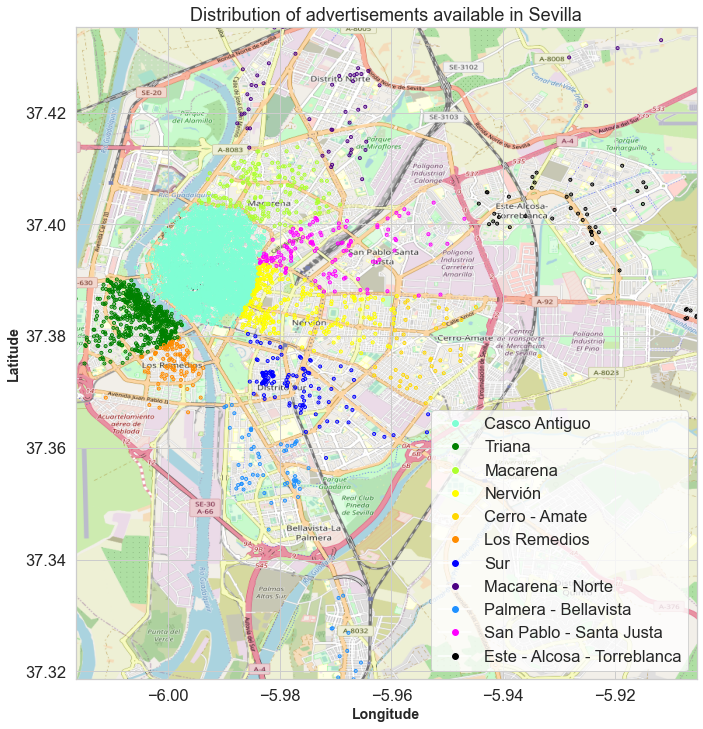

In [1160]:
# Library needed for the legend
from matplotlib.lines import Line2D

BBox = ((listing.longitude.min(), listing.longitude.max(), listing.latitude.min(), listing.latitude.max()))

sev_m = plt.imread('Images/Sevilla_map.png')

colors = {'Casco Antiguo':'aquamarine', 'Triana':'green', 'Macarena':'greenyellow', 'Nervión':'yellow',
          'Cerro - Amate':'gold', 'Los Remedios':'darkorange', 'Sur':'blue', 'Macarena - Norte':'indigo',
          'Palmera - Bellavista':'dodgerblue', 'San Pablo - Santa Justa':'fuchsia', 'Este - Alcosa - Torreblanca':'black'}

fig, ax = plt.subplots(figsize = (12,12))
ax.scatter(listing.longitude, listing.latitude, c=listing['neighbourhood_group'].map(colors), 
           alpha= 1, s=4, marker='.', linewidths=3)
ax.set_title('Distribution of advertisements available in Sevilla', fontsize=18)
plt.ylabel("Latitude", fontsize=14, fontweight='bold')
plt.xlabel("Longitude", fontsize=14, fontweight='bold')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])



colors = {'aquamarine', 'green', 'greenyellow', 'yellow','gold', '', 'blue', '','', 'darkslategray', 'black'}
neigh = listing.neighbourhood_group.unique()
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Casco Antiguo',markerfacecolor='aquamarine', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Triana',markerfacecolor='green', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Macarena',markerfacecolor='greenyellow', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Nervión',markerfacecolor='yellow', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Cerro - Amate',markerfacecolor='gold', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Los Remedios',markerfacecolor='darkorange', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Sur',markerfacecolor='blue', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Macarena - Norte',markerfacecolor='indigo', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Palmera - Bellavista',markerfacecolor='dodgerblue', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='San Pablo - Santa Justa',markerfacecolor='fuchsia', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Este - Alcosa - Torreblanca',markerfacecolor='black', markersize=8)]

ax.legend(handles=legend_elements, loc='best')

ax.imshow(sev_m, zorder=0, extent = BBox, aspect= 'equal')

`3.` How does the price between neighborhoods change?

In [1161]:
listing.groupby(['neighbourhood_group'])['price'].describe().sort_values(['count'], ascending=False)

count        mean         std   min    25%  \
neighbourhood_group                                                        
Casco Antiguo                3741.0  143.248329  655.073371   0.0  48.00   
Triana                        577.0  122.642981  587.917795  11.0  46.00   
Nervión                       282.0  124.127660  602.645211  10.0  43.00   
Macarena                      164.0   54.530488   59.571314  14.0  26.75   
San Pablo - Santa Justa       128.0   64.914062   65.893140  11.0  30.00   
Sur                           115.0  103.678261  187.204483  14.0  35.00   
Los Remedios                   94.0   70.287234   57.223505   9.0  40.00   
Palmera - Bellavista           66.0   62.287879   66.857544  12.0  25.00   
Macarena - Norte               52.0   52.903846   51.992933  12.0  23.00   
Este - Alcosa - Torreblanca    47.0   70.404255   95.400907  15.0  26.00   
Cerro - Amate                  44.0   57.750000   61.506334  12.0  22.00   

                              50%    75%     max  
neighbourhood_group                               
Casco Antiguo                65.0  94.00  9999.0  
Triana                       62.0  87.00  9999.0  
Nervión                      60.0  90.00  9999.0  
Macarena                     39.5  60.00   500.0  
San Pablo - Santa Justa      48.0  72.50   428.0  
Sur                          49.0  78.00  1100.0  
Los Remedios                 55.0  70.75   375.0  
Palmera - Bellavista         40.5  74.00   415.0  
Macarena - Norte             37.5  70.50   350.0  
Este - Alcosa - Torreblanca  40.0  67.00   570.0  
Cerro - Amate                35.0  71.25   350.0

It can be seen some extrem values on the dataset. These outliers will be removed applying IQR method:

In [1162]:
def apply_IQR(data, columns):
    '''
    INPUT:
    data - the dataframe where the IQR will be calculated and apply 
    columns - the columns that the resulting dataframe will have
    OUTPUT:
    df_out - the dataframe with values included only in the IQR
    
    Applies IQR to the dataframe specified by data and will output a new dataframe with only the data
    that fulfills the IQR
    '''
    data_new = data[columns]

    Q1 = data_new.quantile(0.25)
    Q3 = data_new.quantile(0.75)
    IQR = Q3 - Q1

    df_out = data_new[~((data_new < (Q1 - 1.5 * IQR)) |(data_new > (Q3 + 1.5 * IQR))).any(axis=1)]

    print('Rows on the original dataset:', data.shape[0])
    print('Rows on the new dataset after deleting the outliers:', df_out.shape[0])
    print('Deleted rows:', data.shape[0]-df_out.shape[0])
    
    return df_out

new_columns = ['price', 'neighbourhood_group']
listing_new = apply_IQR(listing, new_columns)

Rows on the original dataset: 5310
Rows on the new dataset after deleting the outliers: 4866
Deleted rows: 444


In [1163]:
listing_new.groupby(['neighbourhood_group'])['price'].describe().sort_values(['count'], ascending=False)

count       mean        std   min    25%   50%  \
neighbourhood_group                                                            
Casco Antiguo                3414.0  67.382542  29.518990   0.0  46.00  62.0   
Triana                        525.0  63.900952  27.648587  11.0  45.00  60.0   
Nervión                       256.0  62.351562  31.004640  10.0  40.00  57.0   
Macarena                      159.0  46.377358  27.044660  14.0  26.00  39.0   
San Pablo - Santa Justa       120.0  50.766667  30.374894  11.0  29.75  44.0   
Sur                           104.0  51.990385  28.431999  14.0  33.25  45.0   
Los Remedios                   88.0  58.886364  32.420524   9.0  39.75  53.0   
Palmera - Bellavista           63.0  49.936508  32.325398  12.0  25.00  40.0   
Macarena - Norte               51.0  47.078431  30.941780  12.0  23.00  36.0   
Este - Alcosa - Torreblanca    44.0  48.909091  33.794054  15.0  25.00  39.5   
Cerro - Amate                  42.0  47.619048  36.690500  12.0  22.00  35.0   

                               75%    max  
neighbourhood_group                        
Casco Antiguo                83.00  155.0  
Triana                       80.00  155.0  
Nervión                      82.25  151.0  
Macarena                     60.00  150.0  
San Pablo - Santa Justa      63.25  150.0  
Sur                          61.25  146.0  
Los Remedios                 66.75  150.0  
Palmera - Bellavista         67.50  151.0  
Macarena - Norte             70.00  130.0  
Este - Alcosa - Torreblanca  62.00  141.0  
Cerro - Amate                55.75  150.0

Now the price values have a more reasonable range

In [1164]:
df_1 = listing.groupby(['neighbourhood_group'])['price'].mean()
df_2 = listing_new.groupby(['neighbourhood_group'])['price'].mean()

compare_df = {'Including outliers in price': df_1,
              'Without outliers in price': df_2}

df_new = pd.DataFrame(compare_df, columns=['Including outliers in price', 'Without outliers in price'])

my_colors = list(islice(cycle(['deepskyblue', 'steelblue', 'dodgerblue', 'royalblue', 'navy', 'mediumpurple']), None, len((neighbourhoods.neighbourhood_group.unique()))))


plt.figure(figsize = (14,6))
df_new.plot(kind = "bar", color = my_colors, zorder=2)
plt.title("Average price per neighbourhood. Prices with and without outliers", fontsize=18)
plt.xlabel('Neighbourhood', fontsize=14, fontweight='bold')
plt.ylabel('Price', fontsize=14, fontweight='bold')
plt.axhline(y=listing.price.mean(), linewidth=2, color='r',zorder=1)
plt.axhline(y=listing_new.price.mean(), linewidth=2, color='b',zorder=1)
plt.grid(False)
#plt.ylim(0, 0.8)
plt.show()

<Figure size 1008x432 with 0 Axes>

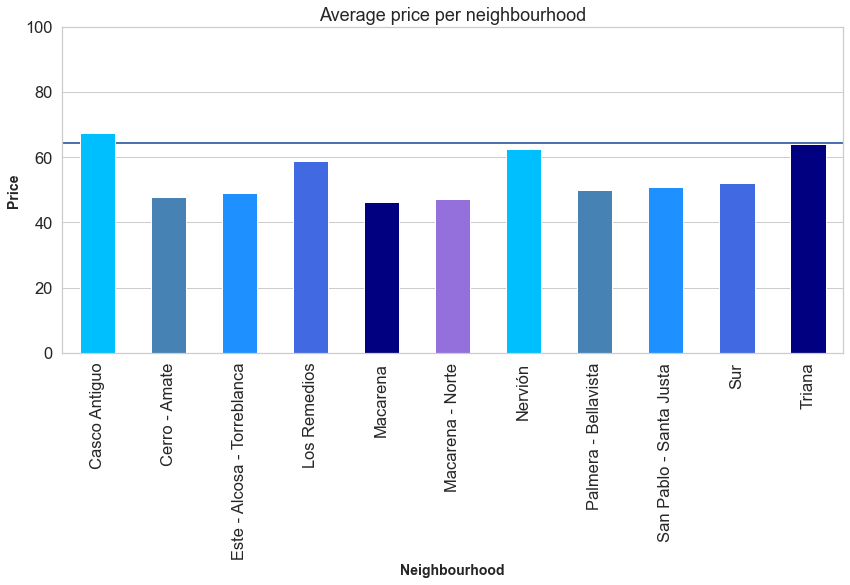

In [1166]:
my_colors = list(islice(cycle(['deepskyblue', 'steelblue', 'dodgerblue', 'royalblue', 'navy', 'mediumpurple']), None, len((neighbourhoods.neighbourhood_group.unique()))))

plt.figure(figsize = (14,6))
listing_new.groupby(['neighbourhood_group'])['price'].mean().plot(kind = "bar", color = my_colors, zorder=2)
plt.title("Average price per neighbourhood", fontsize=18)
plt.xlabel('Neighbourhood', fontsize=14, fontweight='bold')
plt.ylabel('Price', fontsize=14, fontweight='bold')
plt.axhline(y=listing_new.price.mean(), linewidth=2, color='b',zorder=1)
plt.grid(axis='x')
plt.ylim(0, 100)
plt.show()

The overall average price and the average price of "Casco Antiguo" neighbourhood are very closed as expected since the amount of apartments in this zone represents around the 70% of all the offer available in the city

### <a class="anchor" id="Impact-of-the-pandemic">Part IV : Impact of the pandemic</a>

This section is to take a quick look of the impact the pandemic has had in the market

`1.` How has changed the offer through the years?

/Users/petanth/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


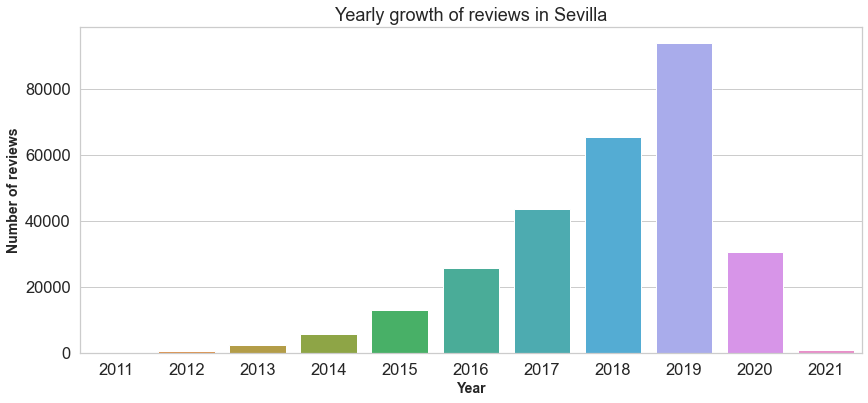

In [1167]:
ax = sns.countplot(review.date_year);
ax.set_title('Yearly growth of reviews in Sevilla', fontsize=18);
ax.set_xlabel('Year', fontsize=14, weight='bold');
ax.set_ylabel('Number of reviews', fontsize=14, weight='bold');

`2.` Did all neighbourhoods experiment the same growth each year?

In [1168]:
review_new = review.rename(columns={"listing_id": "id", "id": "review_id"})
review_new.head(4)

id  review_id       date  reviewer_id reviewer_name  \
0  32347     166105 2011-01-05       177444         Peter   
1  32347     238321 2011-04-25       356558      Nicholas   
2  32347     508902 2011-09-06       723051        Nadine   
3  32347    1056439 2012-03-28       873621         Cathy   

                                                                                                                                                                                                  comments  \
0                                                                                                                                                                           Great location and great host!   
1                                                                                                                                                                      excellent apartment, great location   
2  My  parents and I had a fabulous stay in Alex's apartment. Such a great first experience of stunning Seville. Just as described the apartment is only 5 minutes walk to Sierpes, which is the main s...   
3  We had a fantastic stay.  Alex's apartment is beautiful; clean, uncluttered, yet homely.  Alex was a great host, flexible to our timings, very generous with extra treats and very friendly. Seville...   

   date_year  date_month  date_day date_dayofweek  
0       2011           1         5      Wednesday  
1       2011           4        25         Monday  
2       2011           9         6        Tuesday  
3       2012           3        28      Wednesday

In [1172]:
review_neighbourhood = (pd.merge(review_new, listing, on='id'))
review_neighbourhood.head(2)

id  review_id       date  reviewer_id reviewer_name  \
0  32347     166105 2011-01-05       177444         Peter   
1  32347     238321 2011-04-25       356558      Nicholas   

                              comments  date_year  date_month  date_day  \
0       Great location and great host!       2011           1         5   
1  excellent apartment, great location       2011           4        25   

  date_dayofweek                                                      name  \
0      Wednesday  Explore Cultural Sights from a Family-Friendly Apartment   
1         Monday  Explore Cultural Sights from a Family-Friendly Apartment   

   host_id  host_name neighbourhood_group neighbourhood  latitude  longitude  \
0   139939  Alejandro       Casco Antiguo   San Vicente  37.39468   -6.00183   
1   139939  Alejandro       Casco Antiguo   San Vicente  37.39468   -6.00183   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0  Entire home/apt     99               2                168  2020-01-08   
1  Entire home/apt     99               2                168  2020-01-08   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               1.37                               1               257  
1               1.37                               1               257

In [1173]:
df_plot = review_neighbourhood.groupby(['date_year', 'neighbourhood_group']).size().reset_index().pivot(columns='neighbourhood_group', index='date_year', values=0)
df_plot

neighbourhood_group  Casco Antiguo  Cerro - Amate  \
date_year                                           
2011                          82.0            NaN   
2012                         553.0            8.0   
2013                        1844.0           25.0   
2014                        4262.0           57.0   
2015                       10054.0           76.0   
2016                       19444.0          118.0   
2017                       32239.0          282.0   
2018                       47299.0          559.0   
2019                       68219.0          837.0   
2020                       22921.0          241.0   
2021                         709.0           12.0   

neighbourhood_group  Este - Alcosa - Torreblanca  Los Remedios  Macarena  \
date_year                                                                  
2011                                         NaN           NaN       3.0   
2012                                         NaN          11.0      18.0   
2013                                         2.0          24.0     162.0   
2014                                        23.0          28.0     414.0   
2015                                        23.0         135.0     593.0   
2016                                        76.0         283.0    1198.0   
2017                                       250.0         595.0    1614.0   
2018                                       347.0        1179.0    2405.0   
2019                                       588.0        1658.0    3349.0   
2020                                       191.0         609.0     804.0   
2021                                         4.0          17.0      13.0   

neighbourhood_group  Macarena - Norte  Nervión  Palmera - Bellavista  \
date_year                                                              
2011                              NaN      NaN                   NaN   
2012                              2.0     79.0                   NaN   
2013                             40.0    122.0                   NaN   
2014                             75.0    196.0                  19.0   
2015                            140.0    507.0                  91.0   
2016                            208.0   1341.0                 126.0   
2017                            382.0   2439.0                 264.0   
2018                            647.0   3575.0                 430.0   
2019                            789.0   4736.0                 736.0   
2020                            232.0   1238.0                 176.0   
2021                             10.0     34.0                   5.0   

neighbourhood_group  San Pablo - Santa Justa     Sur  Triana  
date_year                                                     
2011                                     NaN     NaN     NaN  
2012                                     NaN     NaN    31.0  
2013                                    11.0    62.0   124.0  
2014                                    50.0   253.0   353.0  
2015                                   134.0   618.0   766.0  
2016                                   405.0   724.0  1930.0  
2017                                   928.0   831.0  3827.0  
2018                                  1276.0  1292.0  6467.0  
2019                                  2043.0  2076.0  8991.0  
2020                                   584.0   510.0  3112.0  
2021                                    19.0     5.0    64.0

<Figure size 1008x432 with 0 Axes>

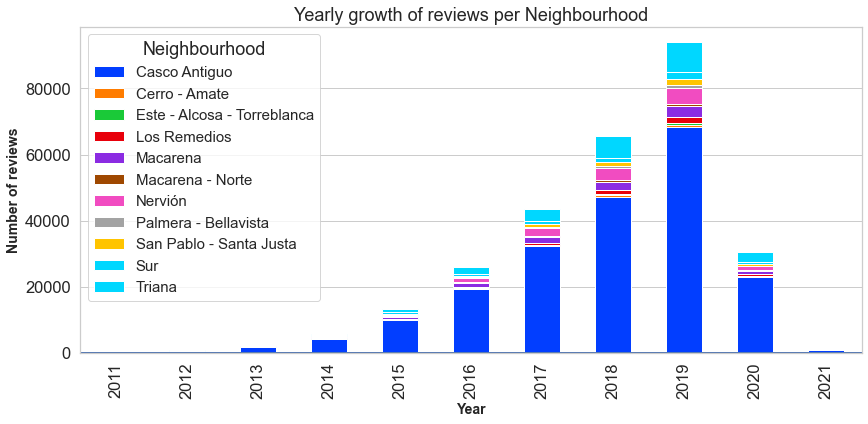

In [1174]:
from matplotlib.colors import ListedColormap

plt.figure(figsize = (14,6))
df_plot.plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("bright", 10)), figsize=(14,6))
plt.title("Yearly growth of reviews per Neighbourhood", fontsize=18)
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Number of reviews', fontsize=14, fontweight='bold')
plt.axhline(y=df_out.price.mean(), linewidth=2, color='b',zorder=1)
plt.grid(axis='x')
plt.legend(title="Neighbourhood", loc='best', fontsize='small', fancybox=True)
plt.show()

As can be seen, the impact has been proportional to the apartment offer on each neighbourhood and has left most of them almost without tourists

### <a class="anchor" id="Popular-words-describing-the-neighborhoods-of-Sevilla">Part V : Popular words describing the neighborhoods of Sevilla</a>

Here will be taken a look at what words usually use people to describe their time in Sevilla

`1.` What are the most used words on some of the popular and not so popular neighborhoods?

In [1175]:
review_neighbourhood.head(2)

id  review_id       date  reviewer_id reviewer_name  \
0  32347     166105 2011-01-05       177444         Peter   
1  32347     238321 2011-04-25       356558      Nicholas   

                              comments  date_year  date_month  date_day  \
0       Great location and great host!       2011           1         5   
1  excellent apartment, great location       2011           4        25   

  date_dayofweek                                                      name  \
0      Wednesday  Explore Cultural Sights from a Family-Friendly Apartment   
1         Monday  Explore Cultural Sights from a Family-Friendly Apartment   

   host_id  host_name neighbourhood_group neighbourhood  latitude  longitude  \
0   139939  Alejandro       Casco Antiguo   San Vicente  37.39468   -6.00183   
1   139939  Alejandro       Casco Antiguo   San Vicente  37.39468   -6.00183   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0  Entire home/apt     99               2                168  2020-01-08   
1  Entire home/apt     99               2                168  2020-01-08   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               1.37                               1               257  
1               1.37                               1               257

In [1176]:
# The text will be included in a new column
review_neighbourhood['text'] = review_neighbourhood['comments'].fillna('')

In [1177]:
print('Rows with NaN values in the \'comments\' column:', np.sum(review_neighbourhood.comments.isnull()))
print('Rows with NaN values in the new \'text\' column:', np.sum(review_neighbourhood.text.isnull()))

Rows with NaN values in the 'comments' column: 105
Rows with NaN values in the new 'text' column: 0


In [1178]:
# Punctuation will be removed from the text
def remove_punctuation(text):
    no_punctuation = "".join([c for c in text if c not in string.punctuation])
    return no_punctuation

review_neighbourhood['tokenized'] = review_neighbourhood['text'].apply(lambda x: remove_punctuation(x))

In [1179]:
# Here we will tokenize the words in the text
tokenizer = RegexpTokenizer(r'\w+')

review_neighbourhood['tokenized'] = review_neighbourhood['tokenized'].apply(lambda x: tokenizer.tokenize(x.lower()))

In [1180]:
# A list of stop words will be defined
more_stopwords = ['walking distance', 'apartment', 'well located', 'everything needed', 'everything need', 
                  'room', 'place', 'house', 'bedroom', 'great place', 'great host','great location', 'gave us',
                  'nous avons', 'location', 'located', 'flat', 'welcome', 'private room', 'home', 'studio', 
                  'close', 'two', 'nice', 'everything need', 'appartement très', 'gave us', 'gave u', 
                  'appartement trè', 'casa', 'apartamento', 'piso', 'alfredo', 'adriano', 'bu', 'goodcasa', 
                  'manuel', 'carmen', 'isabel', 'montserrat','habitación', 'jose', 'esther']

stopwords_eng_spa = stopwords.words('english') + stopwords.words('spanish') + stopwords.words('french') + more_stopwords

def remove_stopwords(text):
    words = [w for w in text if w not in stopwords_eng_spa]
    return words

In [1181]:
# Remove the stop words of the tokenized text
review_neighbourhood['tokenized'] = review_neighbourhood['tokenized'].apply(lambda x: remove_stopwords(x))

In [1182]:
review_neighbourhood.tokenized

0                                                                                                                                                                                            [great, great, host]
1                                                                                                                                                                                              [excellent, great]
2         [parents, fabulous, stay, alexs, great, first, experience, stunning, seville, described, 5, minutes, walk, sierpes, main, shopping, street, also, large, department, store, many, small, supermarket...
3         [fantastic, stay, alexs, beautiful, clean, uncluttered, yet, homely, alex, great, host, flexible, timings, generous, extra, treats, friendly, seville, wonderful, city, perfectly, placed, explore, ...
4         [loved, staying, alexs, fantastic, minutes, away, main, sites, attractions, charming, street, clean, well, equipped, comfortable, little, bit, noisy, 

### Casco Antiguo

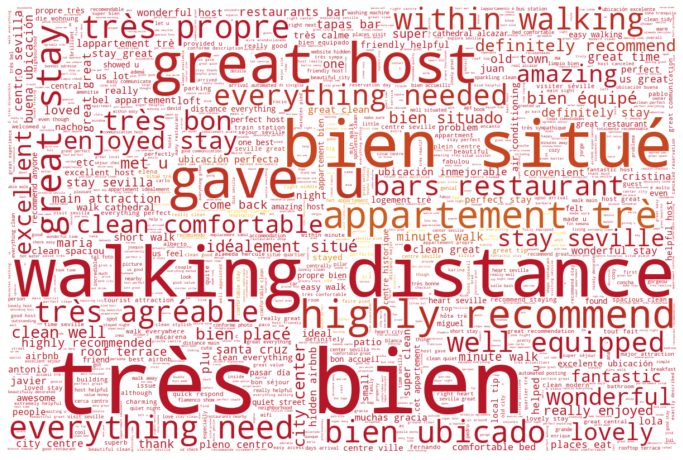

In [1183]:
# Generate a word cloud image
listing_casco_antiguo = review_neighbourhood[review_neighbourhood.neighbourhood_group == 'Casco Antiguo']
mask = np.array(Image.open("Images/sevilla.png"))
wordcloud_spa = WordCloud(width=2000, height=1000, background_color="white", max_words=1000, mask=mask).generate(listing_casco_antiguo['tokenized'].to_string())

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[12,10])
plt.imshow(wordcloud_spa.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.show()

### Triana

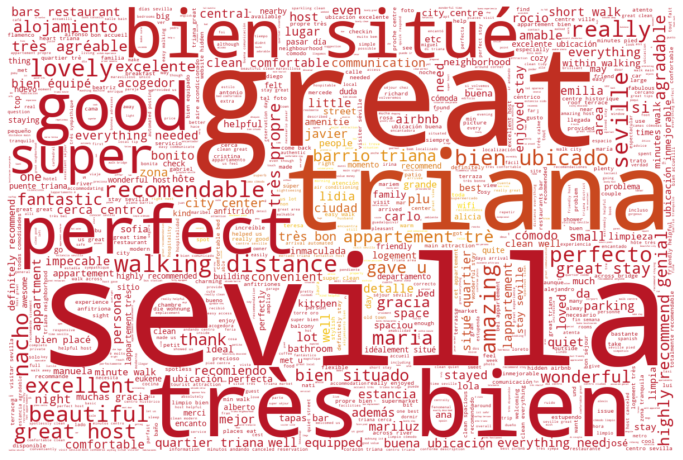

In [1184]:
# Generate a word cloud image
listing_Triana = review_neighbourhood[review_neighbourhood.neighbourhood_group == 'Triana']
mask = np.array(Image.open("Images/sevilla.png"))
wordcloud_spa = WordCloud(width=2000, height=1000, background_color="white", max_words=1000, mask=mask).generate(listing_Triana['tokenized'].to_string())

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[12,10])
plt.imshow(wordcloud_spa.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.show()

### Macarena

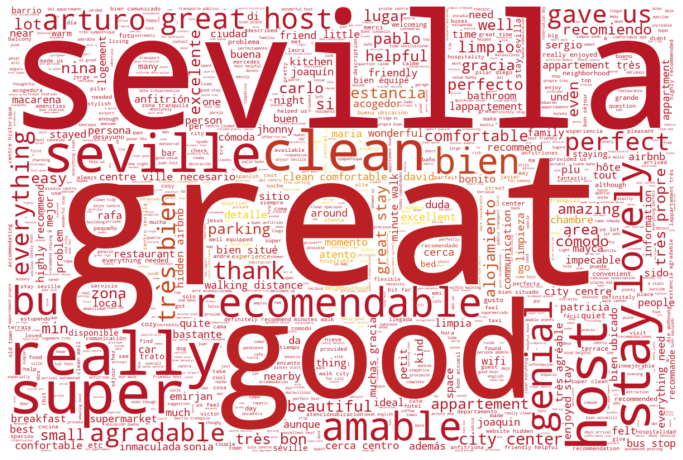

In [1107]:
# Generate a word cloud image
listing_Macarena = review_neighbourhood[review_neighbourhood.neighbourhood_group == 'Macarena']
mask = np.array(Image.open("Images/sevilla.png"))
wordcloud_spa = WordCloud(width=2000, height=1000, background_color="white", max_words=1000, mask=mask).generate(listing_Macarena['tokenized'].to_string())

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[12,10])
plt.imshow(wordcloud_spa.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.show()

### Nervión

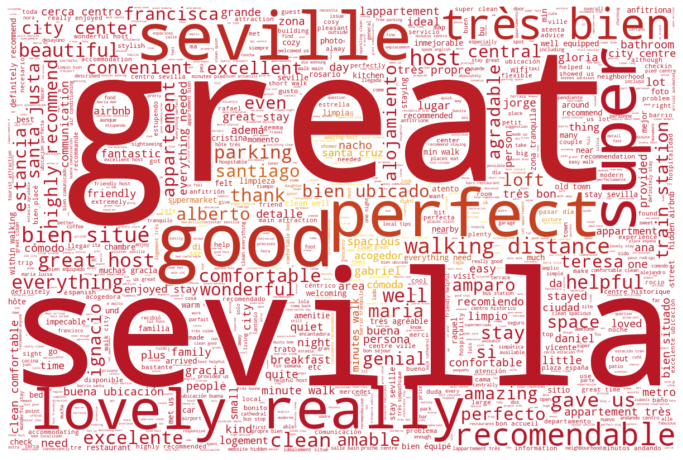

In [1185]:
# Generate a word cloud image
listing_Nervión = review_neighbourhood[review_neighbourhood.neighbourhood_group == 'Nervión']
mask = np.array(Image.open("Images/sevilla.png"))
wordcloud_spa = WordCloud(width=2000, height=1000, background_color="white", max_words=1000, mask=mask).generate(listing_Nervión['tokenized'].to_string())

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[12,10])
plt.imshow(wordcloud_spa.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.show()

### Macarena - Norte

In [1186]:
# Generate a word cloud image
listing_Macarena_Norte = review_neighbourhood[review_neighbourhood.neighbourhood_group == 'Macarena - Norte']
mask = np.array(Image.open("Images/sevilla.png"))
wordcloud_spa = WordCloud(width=2000, height=1000, background_color="white", max_words=1000, mask=mask).generate(listing_Macarena_Norte['tokenized'].to_string())

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[12,10])
plt.imshow(wordcloud_spa.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.show()

### Este - Alcosa - Torreblanca

In [1187]:
# Generate a word cloud image
listing_Este_Alcosa_Torreblanca = review_neighbourhood[review_neighbourhood.neighbourhood_group == 'Este - Alcosa - Torreblanca']
mask = np.array(Image.open("Images/sevilla.png"))
wordcloud_spa = WordCloud(width=2000, height=1000, background_color="white", max_words=1000, mask=mask).generate(listing_Este_Alcosa_Torreblanca['tokenized'].to_string())

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[12,10])
plt.imshow(wordcloud_spa.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.show()

`2.` What are the most used words on the whole city?

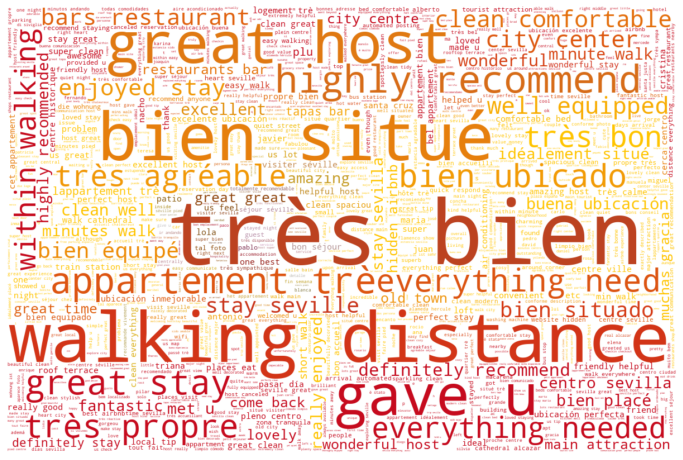

In [1188]:
# Generate a word cloud image
wordcloud_spa = WordCloud(width=2000, height=1000, background_color="white", max_words=1000, mask=mask).generate(review_neighbourhood['tokenized'].to_string())

# create coloring from image
mask = np.array(Image.open("Images/spain.png"))
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[12,10])
plt.imshow(wordcloud_spa.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

### Various not used

In [ ]:
listing_casco_antiguo = review_neighbourhood[review_neighbourhood.neighbourhood_group == 'Casco Antiguo']
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, normalize_plurals=False).generate(listing_casco_antiguo['tokenized'].to_string())
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

In [ ]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, normalize_plurals=False).generate(listing_casco_antiguo['tokenized'].to_string())
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

In [ ]:
plt.figure(figsize = (14,8))
with sns.color_palette("Paired", 20):
    ax = sns.scatterplot(x=listing['latitude'], y=listing['longitude'], hue=listing["neighbourhood_group"], s=20, zorder=1)
ax.set_title('Distribution of apartment prices');
#plt.grid(False)

In [ ]:
listing.neighbourhood_group.unique()

In [ ]:
calendar.groupby(['date_month'])['price', 'adjusted_price'].mean()

x = calendar.groupby(['date_month'])['price']

mean_price = calendar.price.mean()

my_colors = list(islice(cycle(['deepskyblue', 'steelblue', 'dodgerblue', 'royalblue', 'navy', 'mediumpurple']), None, len((neighbourhoods.neighbourhood_group.unique()))))

plt.figure(figsize = (14,6))
calendar.groupby(['date_month'])['price', 'adjusted_price'].mean().plot(kind="bar", color=my_colors, stacked=False)
plt.title("Percentage of advertisements on each neighbourhood group", fontsize=18)
plt.xlabel('Neighbourhood name', fontsize=14, fontweight='bold')
plt.ylabel('%', fontsize=14, fontweight='bold')
plt.show()

In [ ]:
# Check who visited Sevilla many times
review[review.duplicated(subset = 'reviewer_id')]
review[review.reviewer_id == 140267600]
review.groupby('reviewer_id').count().sort_values(by='id', ascending=False)
review[review.reviewer_id == 140267600].sort_values(by='date_year', ascending=False)

In [ ]:
listing.neighbourhood_group

In [ ]:
review.id.describe()

In [ ]:
review.listing_id.describe()

In [ ]:
calendar.head()

In [ ]:
calendar.head()

In [ ]:
# Check values ordered by year
calendar.sort_values(by='date_year', ascending=False)

In [ ]:
# Use of IQR (Interquantile Range) to detect outliers in price
Q1 = calendar.quantile(0.25)
Q3 = calendar.quantile(0.75)
IQR = Q3 - Q1
print(Q1)
print(Q3)
print(IQR)

x = 4 - 1.5 * 6
y = 10 + 1.5 * 6
print(x)
print(y)

In [ ]:
calendar.shape

In [ ]:
Q1_price = calendar.price.quantile(0.25)
Q3_price = calendar.price.quantile(0.75)
IQR_price = Q3_price - Q1_price
print(IQR_price)

print(calendar.price)
print(Q1_price - 1.5 * IQR_price)
print(Q1_price + 1.5 * IQR_price)
print((calendar.price < (Q1_price - 1.5 * IQR_price)) |(calendar.price > (Q1_price + 1.5 * IQR_price)).any())

In [ ]:
calendar_red = calendar[['price']]
print(calendar_red.head())
print(calendar_red.shape)

Q1_price = calendar_red.quantile(0.25)
Q3_price = calendar_red.quantile(0.75)
IQR_price = Q3_price - Q1_price
print(IQR_price)
calendar_red.price.dtype
x = Q1_price - 1.5 * IQR_price
y = Q1_price + 1.5 * IQR_price
print(x)
print(y)
calendar_red.describe()

In [ ]:
calendar_red = calendar_red.sort_values(by='price')

In [ ]:
print(~((calendar_red < x)|
        (calendar_red > y)))

In [ ]:
x = Q1_price - 1.5 * IQR_price
y = Q1_price + 1.5 * IQR_price
calendar_out = calendar_red[~((calendar_red < x)|(calendar_red > y)).any(axis=1)]
print(calendar_out.shape)
print(calendar_red.shape)

calendar.groupby(['date_month'])['price', 'adjusted_price'].mean()

sns.boxplot(x=calendar_out['price'])

plt.ylim(0, 1100)
calendar.groupby(['date_month'])['price'].mean().plot(kind='bar', title = 'Average price over the months');

In [ ]:
sns.boxplot(x=calendar_out['price'])

In [ ]:
plt.ylim(0, 1100)
calendar.groupby(['date_month'])['price'].mean().plot(kind='bar', title = 'Average price over the months');